In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

SEED = 225
tf.keras.utils.set_random_seed(SEED)


gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Tensorflow Version: {tf.__version__}')
gpus = tf.config.experimental.get_device_details(gpus[0])
print(f'Device: {gpus["device_name"]}\nCompute Capability: {gpus["compute_capability"]}')

Tensorflow Version: 2.13.0
Device: NVIDIA GeForce GTX 1070
Compute Capability: (6, 1)


In [2]:
VOCAB_SIZE = 15000
SEQUENCE_LENGTH = 25
V_SPLIT = 0.15
T_SPLIT = 0.15
BATCH_SIZE = 64
EMBED_DIMS = 256
LATENT_DIMS = 1024

In [3]:
df = pd.read_table('./spa-eng/spa.txt', sep='\t', header=None, names=['src', 'dst'])

for i in range(df.shape[0]):
    x = df.iloc[i, 1]
    df.iloc[i, 1] = f'[start] {x} [end]'

df = df.sample(df.shape[0])
df.sample(3)

,src,dst
81158,Tom doesn't think before he speaks.,[start] Tom no piensa antes de hablar. [end]
738,Seize him!,[start] ¡Cogedlo! [end]
94483,All three of my sons were born in Boston.,[start] Mis tres hijos nacieron en Boston. [end]


In [4]:
import string
import re

strip_chars = string.punctuation + '¿'
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f'{re.escape(strip_chars)}', '')

In [5]:
source_vectorization = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
)

target_vectorization = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH + 1,
    standardize=custom_standardization,
)


In [6]:
val_lim = int(V_SPLIT * df.shape[0])
test_lim = int((V_SPLIT + T_SPLIT) * df.shape[0])

val_pairs = df[:val_lim]
test_pairs = df[val_lim : test_lim]
train_pairs = df[ test_lim : ]

'Train, Validation and Test set size:', len(train_pairs), len(val_pairs), len(test_pairs)

('Train, Validation and Test set size:', 83275, 17844, 17845)

In [7]:
train_src_texts = [ x for x in train_pairs['src'] ]
train_dst_texts = [ x for x in train_pairs['dst'] ]

source_vectorization.adapt(train_src_texts)
target_vectorization.adapt(train_dst_texts)

In [8]:
def format_dataset(src, dst):
    src = source_vectorization(src)
    dst = target_vectorization(dst)
    return ({
        'source': src,
        'destination': dst[ :, : -1],
    }, dst[ :, 1 : ])


def make_dataset(pairs):
    src_txts, dst_txts = pairs['src'], pairs['dst']
    src_txts = list(src_txts)
    dst_txts = list(dst_txts)
    
    dataset = tf.data.Dataset.from_tensor_slices((src_txts, dst_txts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()
    

In [9]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, targets in train_ds.take(1):
    print(inputs['source'].shape, inputs['destination'].shape, targets.shape)

(64, 25) (64, 25) (64, 25)


In [10]:
source = keras.Input(shape=(None,), dtype='int64', name='source')
x = keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIMS, mask_zero=True)(source)

encoded_sources = keras.layers.Bidirectional(
    keras.layers.GRU(units=LATENT_DIMS), merge_mode='sum'
)(x)

In [11]:
past_targets = keras.Input(shape=(None,), dtype='int64', name='destination')
x = keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIMS, mask_zero=True)(past_targets)

decoder_gru = keras.layers.GRU(units=LATENT_DIMS, return_sequences=True)
x = decoder_gru(inputs=x, initial_state=encoded_sources)
x = keras.layers.Dropout(0.5)(x)

target_next_step = keras.layers.Dense(VOCAB_SIZE, activation='softmax')(x)


model = keras.Model([source, past_targets], target_next_step)

In [14]:
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
1302/1302 [==============================] - 158s 110ms/step - loss: 4.6681 - accuracy: 0.3287 - val_loss: 3.8581 - val_accuracy: 0.4025
Epoch 2/15
1302/1302 [==============================] - 129s 99ms/step - loss: 3.7435 - accuracy: 0.4233 - val_loss: 3.2612 - val_accuracy: 0.4759
Epoch 3/15
1302/1302 [==============================] - 131s 100ms/step - loss: 3.2765 - accuracy: 0.4742 - val_loss: 2.9184 - val_accuracy: 0.5191
Epoch 4/15
1302/1302 [==============================] - 133s 102ms/step - loss: 2.9462 - accuracy: 0.5104 - val_loss: 2.6846 - val_accuracy: 0.5498
Epoch 5/15
1302/1302 [==============================] - 132s 102ms/step - loss: 2.6877 - accuracy: 0.5390 - val_loss: 2.5186 - val_accuracy: 0.5722
Epoch 6/15
1302/1302 [==============================] - 130s 100ms/step - loss: 2.4762 - accuracy: 0.5630 - val_loss: 2.3891 - val_accuracy: 0.5917
Epoch 7/15
1302/1302 [==============================] - 131s 101ms/step - loss: 2.2955 - accuracy: 0.5849 - val_l

Text(0.5, 0.98, 'Loss and Accuracy')

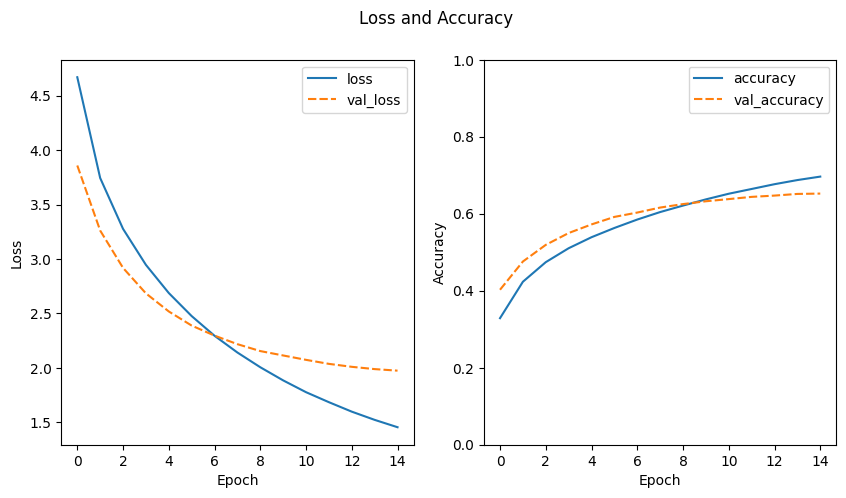

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy")